# CS 182 Project Option 3 -- AI-based Coverage Analysis

Harsh Vardhan Sharma,
Hin Kit Eric Wong,
Harsh Patel


## Introduction

For this option, you are going to fine tune a transformer model, [BERT](https://huggingface.co/bert-base-uncased), for coverage prediction.

The program under test (PUT) is a simple word frequency counter [wf](https://pkgs.org/download/wf) from Fedora 27 RPM repository. It counts the frequency of words in a text file (.txt file). We want BERT to predict the edge coverage of wf when processing a given text file. Therefore, the inputs and outputs of BERT are:
- Input: a string containing all the content in the input text file, e.g., "The dog runs away.".
- Output: a list of 1's and 0's, where 1 means the corresponding edge is exercised and 0 means not, e.g., [1, 1, 0, 1, 0, ...].

## Activate GPU Computing

- Select "Runtime" in the top menu.
- Select "Change runtime type".
- Click on "T4 GPU" under "Hardware accelerator".

## Mount the Drive and Change to the Working Directory

It is recommended to mount your Google Drive on your runtime to ease the data access and storage.

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change to your working directory of CS 182 project
import os
# path = "/content/drive/MyDrive/UC Riverside/23-24 Q1 Fall/CS182/CS182_Team/Project #3"
#path = "/content/drive/MyDrive/CS182/CS182_Team/Team27 - Project #3" # Check files requirements
#path = "/content/drive/MyDrive/CS182_Team/Team27 - Project #3"
path = "/content/drive/MyDrive/Team27 - Project #3"
os.chdir(path)
os.listdir(path)

['training-data.csv',
 'wf-src',
 'IMG_6336.HEIC',
 'training-data.gsheet',
 'training-data-processed-multi-hot-vector (1).gsheet',
 'training-data-processed-multi-hot-vector.gsheet',
 'training-data-processed-multi-hot-vector.csv',
 'CS182_project_option_3_Harsh_Harsh_Eric.ipynb',
 'bert_model_state_v0.pt',
 'Version 0.ipynb',
 'Version 1.ipynb',
 'Team27 - Testing Notes.gdoc',
 'CS182 report.gdoc',
 'Version 2.ipynb']

## Import and Preprocess the Training Data

A set of 2,000 text files and their corresponding coverages is named as training-data.csv and is available [here](https://drive.google.com/file/d/1b4uHAxhez_GnjWVON6YM6DegzvTbla_9/view?usp=sharing). You can use it for fine tuning.

However, it is also highly recommended to generate your own one; to do this, you can use the Python package [nltk](https://www.nltk.org/) to randomly generate text files, compile and instrument [wf](https://drive.google.com/file/d/13FHnPR5DHE5t9UrS6QpoJqFzqrFL_FLy/view?usp=sharing) using [afl-gcc](https://lcamtuf.coredump.cx/afl/), and then use [afl-showmap](https://lcamtuf.coredump.cx/afl/) to collect the coverages.

Assume you have saved the file training-data.csv in your current working directory, you will need to:
1. Import the file as a DataFrame.
2. Combine the coverages (i.e., values of "branch1" to "branch59") for each text file into a single list and append this list as a new column.
3. Create a new DataFrame to store two columns: input text and combined coverage.

In [ ]:
import pandas as pd

In [ ]:
# Import the training data
df = pd.read_csv("./training-data.csv")
# Combine edge coverages into a list
# edge_coverage_columns = df.columns[1:-1] #input-text, branch1...branch 58
edge_coverage_columns = df.columns[2:] #input-text, branch1...branch 58
# print(edge_coverage_columns)

# Change if necessary: The input text is appended together BEFORE with the coverage map (0s,1s)
df["coverage"] = df.apply(lambda row: row[edge_coverage_columns].tolist(), axis=1)
# print(df["coverage"]) # prints the rows.

# Create a new DataFrame called "new_df" with two columns: input text and combined coverage
new_df = df[["input-text", "coverage"]]

# Optional: print out the number of edges and the first five records for checking
checking_edges = len(edge_coverage_columns)
print(f"Number of edges: {checking_edges}")

new_df
# new_df.to_csv("./checking_new_df.csv")

Number of edges: 59


,input-text,coverage
0,Kate pilifer sa Astrid strumpetlike siphonopho...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,meerschaum tetraprostyle A sedentariness squdg...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,raucity Huk Q rivell overcrowdedness unsmoky n...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,cypres ni urease resurprise boat homostyled ap...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,pseudopneumonia heredosyphilogy E Z ribbonmake...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...
1995,garbell roentgenologic oligodactylia Wagnerian...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1996,fish exarch extravagantness paracoele agricolo...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1997,stipulae wyn examinationism bel yo as duramen ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1998,Q sentient lofter baw no collingual Os rotalif...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Prepare Dependencies

In [ ]:
# Install the transformers library
!pip install transformers

## Create the Dataset and Dataloader

You need to create a Dataset to preprocess the text files before feeding them into the BERT model and a Dataloader to feed the training data in batches to the model. Dataset and Dataloader are constructs in [PyTorch library](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for data preprocessing.

In [ ]:
import transformers
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import Dataset, DataLoader

Before creating your own Dataset and Dataloader, you need to define some hyperparameters. Please modify the batch sizes and learning rate when fine tuning the model for better performance.

In [ ]:
# Model checkpoint in Hugging Face
MODEL_NAME = "bert-base-uncased"

# The number of words in each string (i.e., text file) in training-data.csv doesn't exceed 100
MAX_LEN = 100

# Number of edges available in training-data.csv
num_output_features = len(df.columns) - 3 # Subtracting the non-output columns
print(num_output_features)

# I.e., the output dimension
NUM_EDGE = num_output_features

# Batch sizes of training subset and validation subset
TRAIN_BATCH_SIZE = 20
VALID_BATCH_SIZE = 20

# Learning rate of the model
LEARNING_RATE = 5e-5
#LEARNING_RATE = 75e-7
# print(df.at(2))

59


You can use BERT tokenizer to tokenize the input strings (i.e., text files).

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Define your own Dataset.
- Input: the training data DataFrame, the max length of strings, and the tokenizer.
- Output: tokenized string (i.e., input_ids, attention_mask, and token_type_ids) and coverage.

Please refer to the [BERT model documentation](https://huggingface.co/docs/transformers/model_doc/bert) for more details.

In [ ]:
import ast

class CustomDataset(Dataset):
    def __init__(self, data_frame, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = data_frame
        self.texts = data_frame['input-text']
        self.targets = data_frame['coverage']

        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        # curr_text = self.texts[index] # buggy.
        curr_text = self.texts.iloc[index] # Use iloc to access the DataFrame row by position
        # Ensure that self.targets is a list or a 1-D NumPy array of lists before it's indexed.
        curr_target = torch.tensor(self.targets[index], dtype=torch.float32)

        model_inputs = self.tokenizer.encode_plus(
            # TODO
            curr_text,
            max_length=self.max_len,
            # pad_to_max_length = True, # deprecated. Do not use.
            padding = 'max_length',
            truncation=True, # warning from training epoch - as BERT takes 512 tokens at maximum
            return_tensors='pt'
        )

        input_ids = model_inputs['input_ids'].flatten()
        attention_mask = model_inputs['attention_mask'].flatten()
        token_type_ids = model_inputs['token_type_ids'].flatten()

        return {
            "input_ids": input_ids, # The tokenized representation of the input text, which BERT will use to understand and process the text.
            "attention_mask": attention_mask, # Indicates to the model which tokens should be paid attention to and which are just padding.
            "token_type_ids": token_type_ids, # Differentiates between multiple sentences in the same input, if applicable.
            "targets": curr_target # The actual output (branch coverage bitmap) for the input text that the model needs to predict.
        }

Create two subsets from the imported data (training-data.csv): training subset and validation subset.
- Training subset: to fine tune the model; TRAINING_DATA_RATIO (e.g., 90%) of the imported data.
- Validation subset: to evaluate the performance of the model; this subset is invisible to the model during fine tuning.

In [ ]:
TRAINING_DATA_RATIO = 0.9

split_index = int(len(new_df) * TRAINING_DATA_RATIO)

# train_dataset = # TODO
# valid_dataset = # TODO
# train_dataset = new_df[:split_index]
# valid_dataset = new_df[split_index:]
train_dataset = new_df[:split_index].reset_index(drop=True)
valid_dataset = new_df[split_index:].reset_index(drop=True)


print("Dataset: (Rows, Columns)")
print("FULL dataset: {}".format(new_df.shape))
print("TRAIN dataset: {}".format(train_dataset.shape))
print("VALID dataset: {}".format(valid_dataset.shape))

train_dataset_for_model = CustomDataset(train_dataset, tokenizer, MAX_LEN)
valid_dataset_for_model = CustomDataset(valid_dataset, tokenizer, MAX_LEN)

Dataset: (Rows, Columns)
FULL dataset: (2000, 2)
TRAIN dataset: (1800, 2)
VALID dataset: (200, 2)


Create your own training Dataloader and validation Dataloader to load data to the model in batches.

In [ ]:
train_params = {
    "batch_size": TRAIN_BATCH_SIZE, # set 4 cells ago. 30 & 15.
    "shuffle": True,
    "num_workers": 2 # play with it, 1 or 2 might be more efficient.
}

valid_params = {
    "batch_size": VALID_BATCH_SIZE,
    "shuffle": True,
    "num_workers": 2 # play with it, 1 or 2 might be more efficient.
}

train_data_loader = DataLoader(train_dataset_for_model, **train_params) # DataLoader() - It batches, shuffles, and loads the data efficiently.
valid_data_loader = DataLoader(valid_dataset_for_model, **valid_params)

## Define the BERT Model

You can use the model [bert-base-uncased](https://huggingface.co/bert-base-uncased) from Hugging Face as the base model. Please refer to the [BERT model documentation](https://huggingface.co/docs/transformers/model_doc/bert) for more details.

Set up the GPU usage.

In [ ]:
from torch import cuda
device = "cuda" if cuda.is_available() else "cpu"
print(device)

cuda


Define your model.
- Use the pre-trained BERT model as the base model.
- Add a Dropout layer for regularization.
- Add a Linear layer for coverage predication (i.e., classfication).
- Define which output is passed to the Dropout layer and which output is passed to the Linear layer.

Here is a [tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) on how to build models with PyTorch.

In [ ]:
dropout_layer_rate = 0.3

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()

        #TODO
        self.l1 = BertModel.from_pretrained(MODEL_NAME)
        self.l2 = torch.nn.Dropout(p=dropout_layer_rate)  #PLAY WITH THE P here to see which is the best fit | probability of an element to be zeroed. Default: 0.5
        self.l3 = torch.nn.Linear(self.l1.config.hidden_size, NUM_EDGE) # size of each (input, output) sample
        # self.l3 = torch.nn.Linear(self.l1.config.hidden_size, 768)


    def forward(self, input_ids, attention_mask, token_type_ids):

      output_TODO = self.l1(
            # TODO
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
      # Extract the pooled output from the BERT model output -> bug fix for epoch train
      pooled_output_TODO = output_TODO.pooler_output
      # Pass the pooled output through the dropout layer: l2
      output_2 = self.l2(pooled_output_TODO) # pooler_output is the aggregated information of the entire sequence.
      output = self.l3(output_2)
      return output

Create an instance of the model for fine tuning.

In [ ]:
model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

Define a loss function to evaluate the performance of the model by comparing the predicted output and the expected output. Please refer to the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html#loss-functions) for more details.

In [ ]:
from torch import nn

# loss_fn = nn.BCEWithLogitsLoss() #.80 macro
# loss_fn = nn.BCELoss() # causes an cuda bug.
loss_fn = nn.HuberLoss()

Define an optimizer to update the weights of the model to improve its performance. Please refer to the [PyTorch documentation](https://pytorch.org/docs/stable/optim.html) for more details.

In [ ]:
from torch.optim import SGD
from torch.optim import Adam

# Optimizer
# optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) # find documentation

## Fine Tune the Model

Specify the number of epochs. It defines how many times the entire data will be passed through the model.

In [ ]:
EPOCHS = 20 # TODO

Define a function to fine tune the model. In this function:
- The Dataloader of the training subset passes the training subset to the model.
- The output of the model and the actual coverage are compared to calculate the loss based on the loss function.
- The loss value is used to optimize the weights of the model based on the optimizer.
- Save and print out the loss every 100 steps.

In [ ]:
loss_history = []

def train(epoch):

    model.train()

    for _, data in enumerate(train_data_loader, 0):
        # TODO
        # Extracting data
        input_ids = data['input_ids'].to(device, dtype=torch.long)
        attention_mask = data['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        # Forward pass: this is the step where the model uses its learned weights to make predictions or to evaluate the input data.
        outputs = model(input_ids, attention_mask, token_type_ids)

        # Calculate loss
        loss = loss_fn(outputs, targets)
        # print(f'Checking loss: {loss} & loss.item(): {loss.item()}')
        loss_history.append(loss.item())
        # print(f'Printing loss_history:{loss_history}')

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss every 100 steps
        if _ % 100 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

Fine tune the model for the nominated number of epochs.

things to adjust (note by eric):
- learning rate (LEARNING_RATE)
- epoch size (EPOCHS)
- optimizer
- loss function (loss_fn)
- dropout layer rate (torch.nn.Dropout)
- batch size: small could lead to noisy

In [ ]:
import time

In [ ]:
start_time = time.time()

for epoch in range(EPOCHS):
  # print("epoch {}".format(epoch))
  train(epoch)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The total time for {EPOCHS} epochs was {elapsed_time} seconds.")

Epoch: 0, Loss:  0.3925723135471344
Epoch: 1, Loss:  0.031117523089051247
Epoch: 2, Loss:  0.02718673273921013
Epoch: 3, Loss:  0.02158684842288494
Epoch: 4, Loss:  0.022063635289669037
Epoch: 5, Loss:  0.011340375989675522
Epoch: 6, Loss:  0.009879235178232193
Epoch: 7, Loss:  0.015039123594760895
Epoch: 8, Loss:  0.012578323483467102
Epoch: 9, Loss:  0.010456062853336334
Epoch: 10, Loss:  0.007912837900221348
Epoch: 11, Loss:  0.00912537146359682
Epoch: 12, Loss:  0.007603249046951532
Epoch: 13, Loss:  0.005324371624737978
Epoch: 14, Loss:  0.004536079242825508
Epoch: 15, Loss:  0.006170113105326891
Epoch: 16, Loss:  0.004731579218059778
Epoch: 17, Loss:  0.003477278398349881
Epoch: 18, Loss:  0.0038314673583954573
Epoch: 19, Loss:  0.005837591364979744
The total time for 20 epochs was 643.4078843593597 seconds.


Plot the training loss.

Size of loss_history: 1800


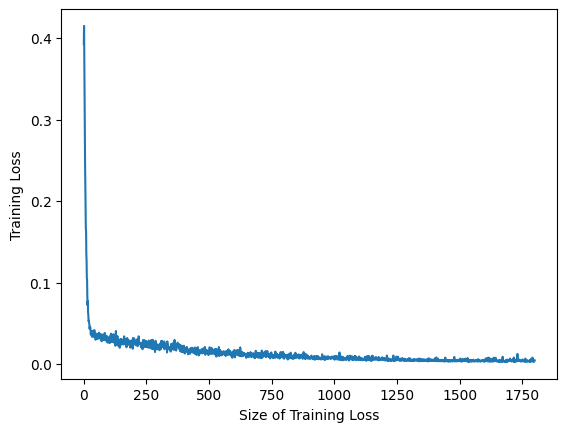

In [ ]:
from matplotlib import pyplot as plt

print(f'Size of loss_history: {len(loss_history)}')

plt.figure()

plt.plot(loss_history)
plt.ylabel("Training Loss")
plt.xlabel("Size of Training Loss") # added by Eric

plt.show()

## Validate the Model

In this part, the validation subset will be passed to the model to evaluate how well the model performs on the unseen data.

Please use the following metrics from the sklearn package for evaluation.
- F1 Micro
- F1 Macro
- Precision Micro
- Precision Macro
- Recall Micro
- Recall Macro

In [ ]:
import numpy as np
from sklearn import metrics

In [ ]:
def validation():
    model.eval()

    validate_targets = []
    validate_outputs = []

    with torch.no_grad():
        for _, data in enumerate(valid_data_loader, 0):
          # TODO
          input_ids = data['input_ids'].to(device, dtype=torch.long)
          attention_mask = data['attention_mask'].to(device, dtype=torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
          targets = data['targets'].to(device, dtype=torch.float)

          outputs = model(input_ids, attention_mask, token_type_ids)

          # Convert outputs to binary (0 or 1) using a threshold (0.5).
          outputs = (outputs > 0.5).float() # Error this is fixing: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

          validate_targets.extend(targets.cpu().numpy().tolist())
          validate_outputs.extend(outputs.cpu().numpy().tolist())

    return validate_outputs, validate_targets


# print(len(valid_dataset))  # Should print the length of the dataset
# valid_dataset
# valid_dataset = valid_dataset.reset_index(drop=True)
# valid_dataset
# print(valid_dataset[125])  # BUGGY: Test accessing near the problematic index
# print(valid_dataset.iloc[125]) # NOT BUGGY

In [ ]:
outputs, targets = validation() #TODO
print(len(outputs), len(targets))

f1_socre_micro = metrics.f1_score(targets, outputs, average = "micro", zero_division=0)
f1_score_macro = metrics.f1_score(targets, outputs, average = "macro", zero_division=0)
precision_micro = metrics.precision_score(targets, outputs, average = "micro", zero_division=0)
precision_macro = metrics.precision_score(targets, outputs, average = "macro", zero_division=0)
recall_micro = metrics.recall_score(targets, outputs, average = "micro", zero_division=0)
recall_macro = metrics.recall_score(targets, outputs, average = "macro", zero_division=0)

print("=== Validation ===")
print(f"F1 score (micro) = {f1_socre_micro}")
print(f"F1 score (macro) = {f1_score_macro}")
print(f"Precision (micro) = {precision_micro}")
print(f"Precision (macro) = {precision_macro}")
print(f"Recall (micro) = {recall_micro}")
print(f"Recall (macro) = {recall_macro}")

200 200
=== Validation ===
F1 score (micro) = 0.9662626580618081
F1 score (macro) = 0.8214324194639997
Precision (micro) = 0.96408753010156
Precision (macro) = 0.8638790285983121
Recall (micro) = 0.9684476230542701
Recall (macro) = 0.8346843853171197


## Save the Model

Save the model for futher usage.

In [ ]:
# model_saving_path = "/content/drive/MyDrive/CS182/Project #3"
model_saving_path = "/content/drive/MyDrive/UC Riverside/23-24 Q1 Fall/CS182/CS182_Team/Project #3"
model_saving_filename = "bert_model_state_v0.pt"

# Combine the path and filename to create a full path to save the file
full_model_saving_path = os.path.join(model_saving_path, model_saving_filename)

# Save the model's state_dict
torch.save(model.state_dict(), full_model_saving_path)

RuntimeError: ignored